## Finding Stream/Tidal Tail

We start by showing spectroscopic data from SDSS and LAMOST. Then we move on to Gaia to use BHB and RRL to trace the stream.

**RA-dependent Proper motion selection**:\
Since the mock Boo III tidal stream showed a proper motion gradient along RA, we use this gradient as part of our data cuts. When we try to identify Boo III stream members using SDSS, LAMOST, and Gaia, we always do a proper motion cut that is dependent on that gradient.

We take our best fit curves (pmra vs. ra and pmdec vs. ra) from the stream model, and for each star from the dataset, we use its RA value to find an expected (pmra, pmdec). Then we use the errors and pm correlation of the star to make a covariance matrix ellipse, and check if the ellipse overlaps the expected pm (since these two things are all in the proper motion space). If they overlap then we select this star in our sample.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy import table, units
from scipy.optimize import curve_fit
import pickle

from galpy.orbit import Orbit
from galpy.util.conversion import get_physical
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf
from galpy.potential.mwpotentials import McMillan17

# Helper functions
from plot_functions import *
from analysis_functions_v2 import *

# params imported from plot_functions
plt.rcParams.update(params)

# Gaia EDR3 correction code
import gaia_edr3

A new version of galpy (1.8.3) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# For citations on values, see notebook Part 1
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

# Isochrone 
dartmouth_isochrone = ascii.read('boo3_iso.iso', header_start=8)
parsec_isochrone = ascii.read('parsec_isochrone.txt', header_start=13)
gr_iso_BHB, g_iso_BHB = get_BHB_iso_color_n_mag()

# Styx stream
styx_trace = ascii.read('styx.trace')

# Stellar locus (Figure 11 in Li et al. 2019 https://academic.oup.com/mnras/article/490/3/3508/5580642)
with fits.open('y3a2_empirical_stellar_locus_griz.fits') as hdu_list:
    stellar_locus = table.Table(hdu_list[1].data)

# 6D parameters
RA_BOO3 = 209.3     # deg  (from Grillmair 2009)
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc  (from Carlin 2018)
PMRA_BOO3 = -1.16   # mas yr^-1  (from Part 1 of this work)
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 191.31   # km s^-1

# Uncertainties (no value for positions)
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 0.75

FEH_BOO3 = -2.31
U_FEH_BOO3 = 0.1

# From Part 1, our sample
boo3_main_members = ascii.read('boo3_main_members.dat')
boo3_main_rrl = ascii.read('boo3_main_rrl.dat')

### Loading the fiducial stream model from Part 2

In [28]:
def get_model_curves(orbit_lead, orbit_trail, trim_range, get_pm_fit_params=False):
    ra = np.append(orbit_lead.ra(), orbit_trail.ra())
    dec = np.append(orbit_lead.dec(), orbit_trail.dec())
    pmra = np.append(orbit_lead.pmra(), orbit_trail.pmra())
    pmdec = np.append(orbit_lead.pmdec(), orbit_trail.pmdec())
    vlos = np.append(orbit_lead.vlos(), orbit_trail.vlos())
    dm = distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist()))
    
    trim = (trim_range[0] < ra) & (ra < trim_range[1])
    
    # Curve fit
    def poly_2deg(x, a, b, c):
        y = a * x**2 + b * x + c
        return y

    p_opt_dec, _ = curve_fit(poly_2deg, ra[trim], dec[trim])
    p_opt_pmra, _ = curve_fit(poly_2deg, ra[trim], pmra[trim])
    p_opt_pmdec, _ = curve_fit(poly_2deg, ra[trim], pmdec[trim])
    p_opt_vlos, _ = curve_fit(poly_2deg, ra[trim], vlos[trim])
    p_opt_dm, _ = curve_fit(poly_2deg, ra[trim], dm[trim])

    x = np.arange(*trim_range, 0.1)

    # Make the model curves
    curve_pmra = np.array([x, poly_2deg(x, *p_opt_pmra)]).T
    curve_pmdec = np.array([x, poly_2deg(x, *p_opt_pmdec)]).T
    curve_rv = np.array([x, poly_2deg(x, *p_opt_vlos)]).T
    curve_dm = np.array([x, poly_2deg(x, *p_opt_dm)]).T
    curve_dec = np.array([x, poly_2deg(x, *p_opt_dec)]).T
    
    # This is just for convenience of the part below 
    # when we do the RA-dependent PM cut we need the pm model params
    if get_pm_fit_params:
        return [p_opt_pmra, p_opt_pmdec]
    
    return [curve_dec, curve_pmra, curve_pmdec, curve_rv, curve_dm]

In [4]:
with open("orbit_lead_fiducial.obj", "rb") as fileObj:
    orbit_leading = pickle.load(fileObj)
with open("orbit_trail_fiducial.obj", "rb") as fileObj:
    orbit_trailing = pickle.load(fileObj)

In [5]:
orbit_curves_fiducial = get_model_curves(orbit_leading, orbit_trailing, [RA_BOO3-20, RA_BOO3+20])

In [12]:
def plot_five_params(ax, orbit_lead, orbit_trail, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax[0].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.dec(), orbit_trail.dec()), **kwargs)
    ax[1].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmra(), orbit_trail.pmra()), **kwargs)
    ax[2].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmdec(), orbit_trail.pmdec()), **kwargs)
    ax[3].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.vlos(), orbit_trail.vlos()), **kwargs)
    ax[4].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist())), **kwargs)

def plot_five_curves(ax, orbit_curves, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax0_kwargs = kwargs.copy()
    ax0_kwargs.pop('label', None)
    
    ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **ax0_kwargs)
    ax[1].plot(orbit_curves[1][:,0], orbit_curves[1][:,1], **kwargs)
    ax[2].plot(orbit_curves[2][:,0], orbit_curves[2][:,1], **kwargs)
    ax[3].plot(orbit_curves[3][:,0], orbit_curves[3][:,1], **kwargs)
    ax[4].plot(orbit_curves[4][:,0], orbit_curves[4][:,1], **kwargs)

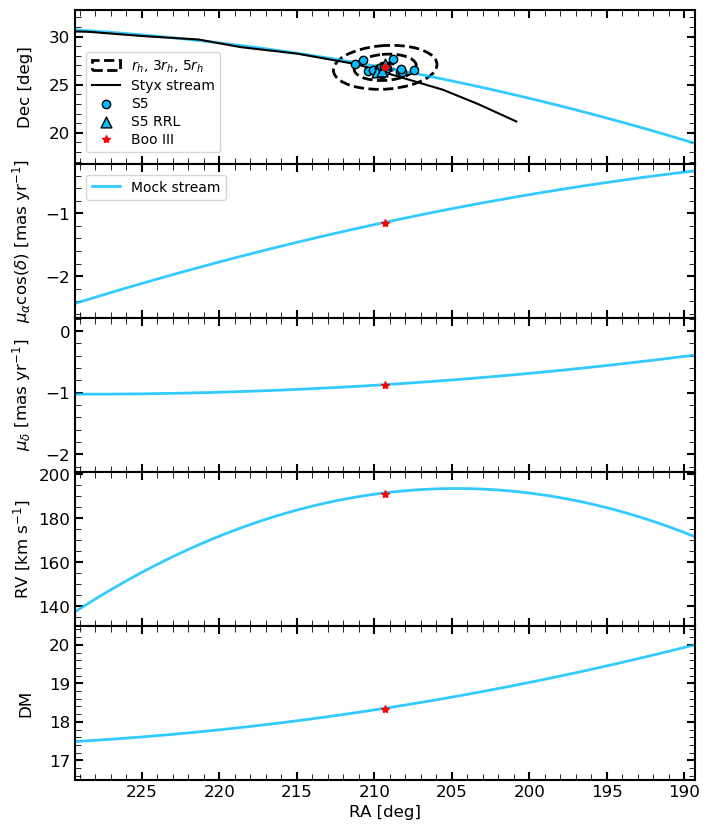

In [21]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_five_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_onsky(fig, ax[0], boo3_main_members, 'S5', marker='o', c='deepskyblue', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'S5 RRL', marker='^', s=60, c='deepskyblue', ec='k', zorder=2)

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[4].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

Here we load all the external data:\
SDSS (10 deg radius from Boo III centre)\
LAMOST (10 deg)\
Gaia (20 deg)\
DECaLS (20 deg)

We want to find spectroscopic members in SDSS and LAMOST, but they don't have proper motion so we pair them with Gaia proper motion.

In [24]:
print("Loading SDSS")
with fits.open('sdss_dr14_10deg.fits') as hdu_list:
    table_sdss = table.Table(hdu_list[1].data)
print("Loading LAMOST")
with fits.open('lamost_dr8_lrs_10deg.fits') as hdu_list:
    table_lamost_lrs = table.Table(hdu_list[1].data)
with fits.open('lamost_dr8_mrs_10deg.fits') as hdu_list:
    table_lamost_mrs = table.Table(hdu_list[1].data)
    
print("Loading Gaia RRL")
with fits.open('gaia_rrl_dr3_all.fits') as hdu_list:
    _table_rrl1 = table.Table(hdu_list[1].data)
with fits.open('GaiaDR3_RRLs_withMu_Lite.fits') as hdu_list:
    _table_rrl2 = table.Table(hdu_list[1].data)
table_rrl = table.join(_table_rrl1, _table_rrl2['source_id', 'EBV_SFD'], keys=['source_id'])

print("Loading DECaLS")
with fits.open('ls_dr9_20deg_box.fits') as hdu_list: #'ls_dr9_over10deg_position_and_mag.fits'
    table_ls = table.Table(hdu_list[1].data)
    
print("Loading Gaia data...")
print("Progress: 0/4", end='\r')
with fits.open('gaia_dr3_20deg_part1.fits') as hdu_list:
    _table_gaia1 = table.Table(hdu_list[1].data)
print("Progress: 1/4", end='\r')
with fits.open('gaia_dr3_20deg_part2.fits') as hdu_list:
    _table_gaia2 = table.Table(hdu_list[1].data)
print("Progress: 2/4", end='\r')
with fits.open('gaia_dr3_20deg_part3.fits') as hdu_list:
    _table_gaia3 = table.Table(hdu_list[1].data)
print("Progress: 3/4", end='\r')
with fits.open('gaia_dr3_20deg_part4.fits') as hdu_list:
    _table_gaia4 = table.Table(hdu_list[1].data)
print("Progress: 4/4")
print("Combining...")
table_gaia_full = table.vstack([_table_gaia1, _table_gaia2, _table_gaia3, _table_gaia4])
print("Complete")

Loading SDSS
Loading LAMOST
Loading Gaia RRL
Loading DECaLS
Loading Gaia data...
Progress: 4/4
Combining...
Complete



In [29]:
p_opt_pmra, p_opt_pmdec = get_model_curves(orbit_leading, orbit_trailing, [RA_BOO3-20, RA_BOO3+20], 
                                           get_pm_fit_params=True)

## SDSS

In [25]:
print("Sample size:", len(table_sdss))

# Add DECaLS magnitudes to SDSS
ls_matched_to_sdss, sep2d = crossmatch(table_sdss, table_ls, sep_dist=0.5, get_sep2d=True)

table_sdss = table.hstack([table_sdss[sep2d < 0.5*units.arcsec], ls_matched_to_sdss['dered_mag_g'], 
                               ls_matched_to_sdss['dered_mag_r'], ls_matched_to_sdss['dered_mag_z']])

print("After adding magnitude:", len(table_sdss))

# Add Gaia proper motion to SDSS
gaia_matched_to_sdss, sep2d = crossmatch(table_sdss, table_gaia_full, sep_dist=0.5, get_sep2d=True)

table_sdss = table.hstack([table_sdss[sep2d < 0.5*units.arcsec], 
                            gaia_matched_to_sdss['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr']])

print("After adding proper motion:", len(table_sdss))

# Take out the rows with no [Fe/H] measurement
table_sdss = table_sdss[table_sdss['fehadopunc'] > -9999]

print("After removing rows without [Fe/H] value:", len(table_sdss))

Sample size: 48381
After adding magnitude: 43837
After adding proper motion: 14016
After removing rows without [Fe/H] value: 6864


In [103]:
# RA-dependent PM cut
table_sdss_pm = pm_cut_with_gradient(table_sdss, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut sample:", len(table_sdss_pm))

table_sdss_pm = table_sdss_pm[(120 < table_sdss_pm['elodiervfinal']) & (table_sdss_pm['elodiervfinal'] < 240)]
print("After removing velocities too far away:", len(table_sdss_pm))

PM cut sample: 77
After removing velocities too far away: 11


In [198]:
def plot_four_panels(ax, data, headers, label, color):
    """
    headers: [ra, dec, pmra, pmdec, pmra_err, pmdec_err, g_mag, r_mag, rv, feh, rv_err, feh_err]
    """
    ax[0].scatter(data[headers[0]], data[headers[1]], c=color, label=label, marker='o', s=70, ec='k', zorder=2)
    ax[1].errorbar(data[headers[2]], data[headers[3]], xerr=data[headers[4]], yerr=data[headers[5]], c=color, label=label, fmt='o', ms=8, mec='k', capsize=0, lw=1)
    ax[2].scatter(data[headers[6]] - data[headers[7]], data[headers[7]], c=color, label=label, marker='o', s=70, ec='k', zorder=2)
    ax[3].errorbar(data[headers[9]], data[headers[8]], xerr=data[headers[11]], yerr=data[headers[10]], c=color, label=label, fmt='o', ms=8, mec='k', lw=1)
    
def plot_four_panels_on_stream(ax, data, headers, label, color):
    """
    headers: [ra, dec, pmra, pmdec, pmra_err, pmdec_err, rv, rv_err]
    """
    ax[0].scatter(data[headers[0]], data[headers[1]], c=color, marker='o', ec='k', zorder=2)#  label=label,
    ax[1].errorbar(data[headers[0]], data[headers[2]], yerr=data[headers[4]], c=color, label=label, fmt='o', mec='k', capsize=0, lw=1)
    ax[2].errorbar(data[headers[0]], data[headers[3]], yerr=data[headers[5]], c=color, label=label, fmt='o', mec='k', capsize=0, lw=1)
    ax[3].errorbar(data[headers[0]], data[headers[6]], yerr=data[headers[7]], c=color, label=label, fmt='o', mec='k', capsize=0, lw=1)


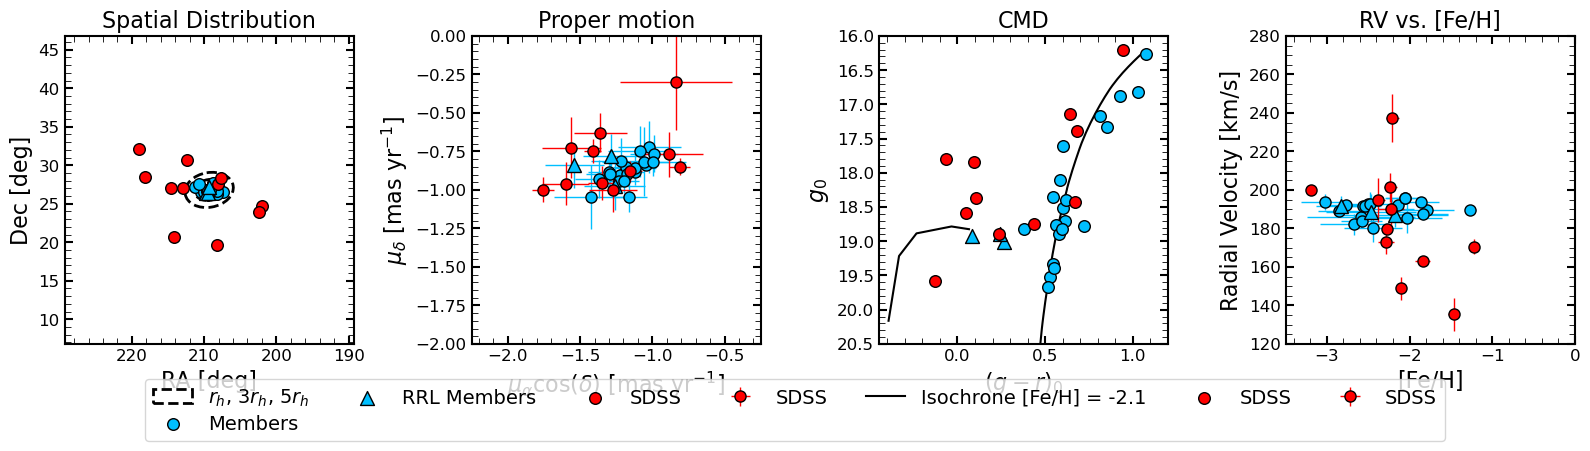

In [104]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4.2))

plot_rh(ax[0])
plot_onsky(fig, ax[0], boo3_main_members, 'Members', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'RRL Members', marker='^', s=100, c='deepskyblue', ec='k', zorder=2)
ax_labels(ax[0], 'RA [deg]', 'Dec [deg]', 'Spatial Distribution')
ax[0].set_xlim(RA_BOO3-20, RA_BOO3+20)
ax[0].set_ylim(DEC_BOO3-20, DEC_BOO3+20)
ax[0].invert_xaxis()

plot_pm_ax(ax[1], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_main_rrl, '', fmt='^', ms=10, c='deepskyblue', mec='k', capsize=0, lw=1)
ax_labels(ax[1], pmra_label, pmdec_label, 'Proper motion')
ax[1].set_xlim(-2.25, -0.25)
ax[1].set_ylim(-2, 0)

plot_RGB_isochrone(ax[2], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], distance_to_dm(DIST_BOO3*1000), 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[2], distance_to_dm(DIST_BOO3*1000), c='k')
plot_cmd(fig, ax[2], boo3_main_members['decam_g0'], boo3_main_members['decam_r0'], '', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_main_rrl['decam_g0'], boo3_main_rrl['decam_r0'], '', marker='^', s=100, c='deepskyblue', ec='k', zorder=2)
ax_labels(ax[2], r'$(g-r)_0$', r'$g_0$', 'CMD')
ax[2].set_xlim(-0.45, 1.2)
ax[2].set_ylim(16, 20.5)
ax[2].invert_yaxis()

plot_rv_metallicity_ax(ax[3], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_main_rrl, '', fmt='^', ms=10, c='deepskyblue', mec='k', lw=1)
ax_labels(ax[3], '[Fe/H]', 'Radial Velocity [km/s]', 'RV vs. [Fe/H]')
ax[3].set_ylim(120, 280)
ax[3].set_xlim(-3.5, 0)

plot_four_panels(ax, table_sdss_pm, 
                 ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 
                  'dered_mag_g', 'dered_mag_r', 'elodiervfinal', 'fehadop', 
                  'elodiervfinalerr', 'fehadopunc'], 'SDSS', 'red')


lgd = fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=7, prop={'size': 14})
plt.tight_layout()

plt.show()

In [192]:
_, _sep2d = crossmatch(table_sdss_pm, table_rrl, get_sep2d=True)
_sdss_rrl = table_sdss_pm[_sep2d < 1*units.arcsec]

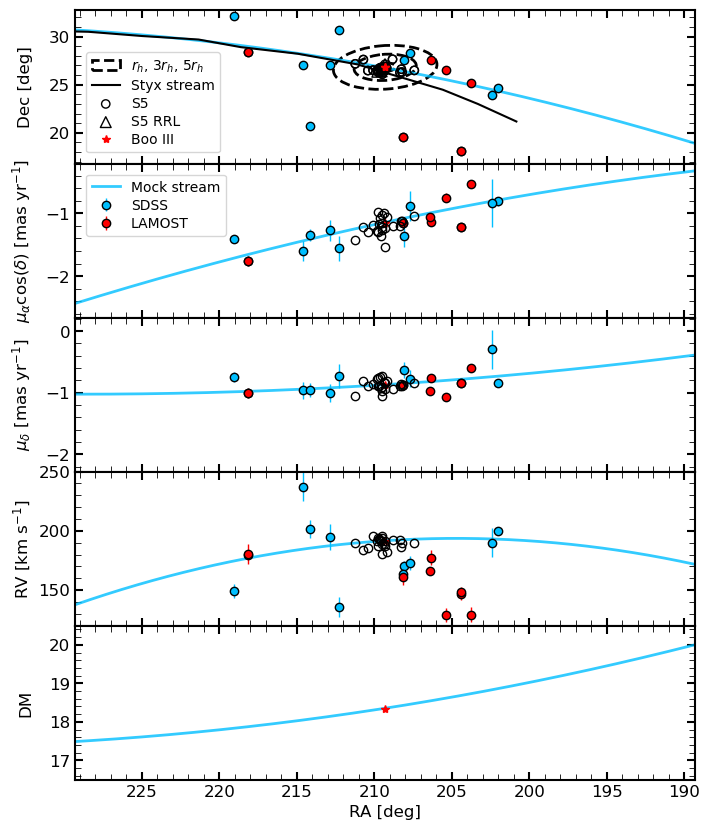

In [200]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_five_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_onsky(fig, ax[0], boo3_main_members, 'S5', marker='o', c='none', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'S5 RRL', marker='^', s=60, c='none', ec='k', zorder=2)

plot_four_panels_on_stream(ax, table_sdss_pm, 
                           ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 
                            'pmdec_error', 'elodiervfinal', 'elodiervfinalerr'], 'SDSS', 'deepskyblue')
# plot_four_panels_on_stream(ax, _sdss_rrl, 
#                            ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 
#                             'pmdec_error', 'elodiervfinal', 'elodiervfinalerr'], 'SDSS RRL', 'magenta')
plot_four_panels_on_stream(ax, table_lamost_lrs_pm, 
                           ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 
                            'pmdec_error', 'rv_corrected', 'rv_err'], 'LAMOST', 'red')
plot_four_panels_on_stream(ax, boo3_main_members, 
                           ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 
                            'pmdec_error', 'vel_calib', 'vel_calib_std'], '', 'none')
plot_four_panels_on_stream(ax, boo3_main_rrl, 
                           ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 
                            'pmdec_error', 'vel_calib', 'vel_calib_std'], '', 'none')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (120, 250), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[4].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
fig.savefig('sdss_lamost.pdf', dpi=300)
plt.show()

## LAMOST

Velocity offset correction from [Liu et al. 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aacf91) LAMOST and APOGEE

In [108]:
table_lamost_lrs['rv_corrected'] = table_lamost_lrs['rv'] + 7.328
table_lamost_mrs['rv_corrected'] = table_lamost_mrs['rv_lasp1'] + 7.328

In [109]:
print("Sample size:", len(table_lamost_lrs), "and", len(table_lamost_mrs))

ls_matched_to_lamostlrs, sep2d = crossmatch(table_lamost_lrs, table_ls, sep_dist=0.5, get_sep2d=True)
table_lamost_lrs = table.hstack([table_lamost_lrs[sep2d < 0.5*units.arcsec], ls_matched_to_lamostlrs['dered_mag_g'], 
                                 ls_matched_to_lamostlrs['dered_mag_r'], ls_matched_to_lamostlrs['dered_mag_z']])

ls_matched_to_lamostmrs, sep2d = crossmatch(table_lamost_mrs, table_ls, sep_dist=0.5, get_sep2d=True)
table_lamost_mrs = table.hstack([table_lamost_mrs[sep2d < 0.5*units.arcsec], ls_matched_to_lamostmrs['dered_mag_g'], 
                                 ls_matched_to_lamostmrs['dered_mag_r'], ls_matched_to_lamostmrs['dered_mag_z']])

print("Assigned magnitudes:", len(table_lamost_lrs), "and", len(table_lamost_mrs))

# Add Gaia proper motion, this time we match by the Gaia source id directly
table_lamost_lrs['source_id'] = np.int64(table_lamost_lrs['gaia_source_id'])
table_lamost_lrs = table.join(table_lamost_lrs, table_gaia_full['source_id', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr'], keys=['source_id'])
table_lamost_mrs['source_id'] = np.int64(table_lamost_mrs['gaia_source_id'])
table_lamost_mrs = table.join(table_lamost_mrs, table_gaia_full['source_id', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr'], keys=['source_id'])

print("Assigned proper motions:", len(table_lamost_lrs), "and", len(table_lamost_mrs))

Sample size: 99148 and 15687
Assigned magnitudes: 88287 and 14938
Assigned proper motions: 86795 and 14787


In [111]:
table_lamost_lrs_pm = pm_cut_with_gradient(table_lamost_lrs, p_opt_pmra, p_opt_pmdec, pad=0.5)
table_lamost_mrs_pm = pm_cut_with_gradient(table_lamost_mrs, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut:", len(table_lamost_lrs_pm), "and", len(table_lamost_mrs_pm))

table_lamost_lrs_pm = table_lamost_lrs_pm[(120 < table_lamost_lrs_pm['rv_corrected']) & (table_lamost_lrs_pm['rv_corrected'] < 240)]
table_lamost_mrs_pm = table_lamost_mrs_pm[(120 < table_lamost_mrs_pm['rv_corrected']) & (table_lamost_mrs_pm['rv_corrected'] < 240)]
print("Again, RV cut (120 to 240):", len(table_lamost_lrs_pm), "and", len(table_lamost_mrs_pm))

PM cut: 164 and 17
Again, RV cut (120 to 240): 8 and 0


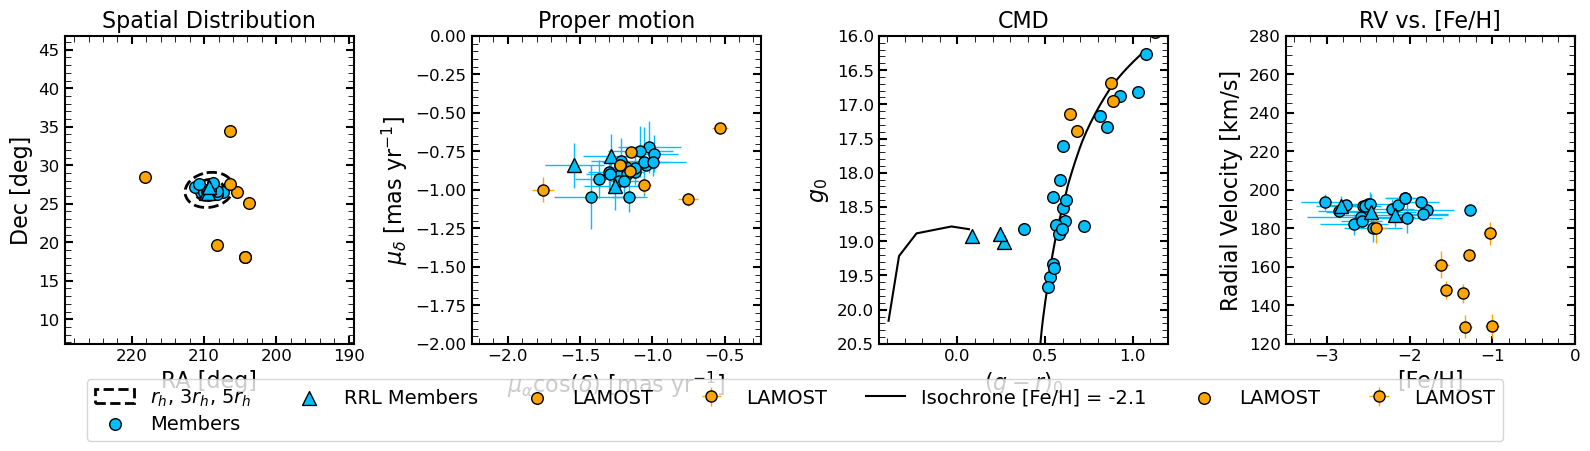

In [114]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4.2))

plot_rh(ax[0])
plot_onsky(fig, ax[0], boo3_main_members, 'Members', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'RRL Members', marker='^', s=100, c='deepskyblue', ec='k', zorder=2)
ax_labels(ax[0], 'RA [deg]', 'Dec [deg]', 'Spatial Distribution')
ax[0].set_xlim(RA_BOO3-20, RA_BOO3+20)
ax[0].set_ylim(DEC_BOO3-20, DEC_BOO3+20)
ax[0].invert_xaxis()

plot_pm_ax(ax[1], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_main_rrl, '', fmt='^', ms=10, c='deepskyblue', mec='k', capsize=0, lw=1)
ax_labels(ax[1], pmra_label, pmdec_label, 'Proper motion')
ax[1].set_xlim(-2.25, -0.25)
ax[1].set_ylim(-2, 0)

plot_RGB_isochrone(ax[2], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], distance_to_dm(DIST_BOO3*1000), 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[2], distance_to_dm(DIST_BOO3*1000), c='k')
plot_cmd(fig, ax[2], boo3_main_members['decam_g0'], boo3_main_members['decam_r0'], '', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_main_rrl['decam_g0'], boo3_main_rrl['decam_r0'], '', marker='^', s=100, c='deepskyblue', ec='k', zorder=2)
ax_labels(ax[2], r'$(g-r)_0$', r'$g_0$', 'CMD')
ax[2].set_xlim(-0.45, 1.2)
ax[2].set_ylim(16, 20.5)
ax[2].invert_yaxis()

plot_rv_metallicity_ax(ax[3], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_main_rrl, '', fmt='^', ms=10, c='deepskyblue', mec='k', lw=1)
ax_labels(ax[3], '[Fe/H]', 'Radial Velocity [km/s]', 'RV vs. [Fe/H]')
ax[3].set_ylim(120, 280)
ax[3].set_xlim(-3.5, 0)

plot_four_panels(ax, table_lamost_lrs_pm, 
                 ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 
                  'dered_mag_g', 'dered_mag_r', 'rv_corrected', 'feh', 
                  'rv_err', 'feh_err'], 'LAMOST', 'orange')

lgd = fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=7, prop={'size': 14})
plt.tight_layout()

plt.show()

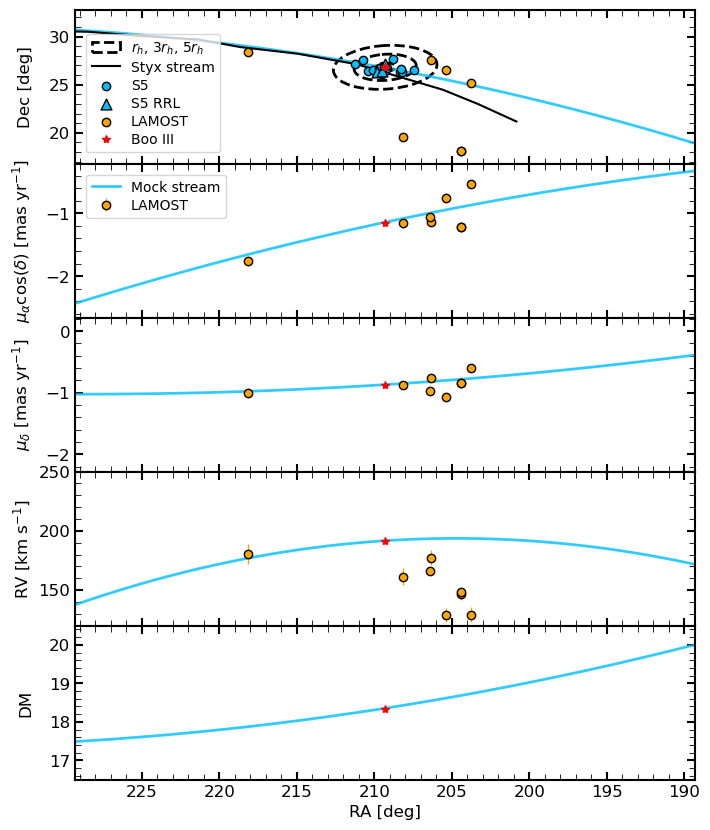

In [115]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_five_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_onsky(fig, ax[0], boo3_main_members, 'S5', marker='o', c='deepskyblue', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'S5 RRL', marker='^', s=60, c='deepskyblue', ec='k', zorder=2)

plot_four_panels_on_stream(ax, table_lamost_lrs_pm, 
                           ['ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 
                            'pmdec_error', 'rv_corrected', 'rv_err'], 'LAMOST', 'orange')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (120, 250), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[4].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

**Note**: In the second last panel (RV), the point closest to the model curve also appears in the SDSS sample, so this is redundant.

## Gaia
The result from SDSS and LAMOST is inconclusive. So now we try BHB and RRL stars in Gaia DR3.

In [116]:
print("Within square box (40 deg in side length):", len(table_gaia_full))

table_gaia_full = angular_radius_cut(table_gaia_full, [RA_BOO3, DEC_BOO3], 20)
print("Within 20 deg radius:", len(table_gaia_full))

ls_matched_to_gaia, sep2d = crossmatch(table_gaia_full, table_ls, sep_dist=0.5, get_sep2d=True)
table_gaia_full = table.hstack([table_gaia_full[sep2d < 0.5*units.arcsec], ls_matched_to_gaia['dered_mag_g'], 
                               ls_matched_to_gaia['dered_mag_r'], ls_matched_to_gaia['dered_mag_z']])
print("Assigned magnitudes:", len(table_gaia_full))

Within square box (40 deg in side length): 4044422
Within 20 deg radius: 3373253
Assigned magnitudes: 3059092


In [117]:
table_gaia_pm_cut = pm_cut_with_gradient(table_gaia_full, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut:", len(table_gaia_pm_cut))

PM cut: 51630


In [118]:
ascii.write(table_gaia_pm_cut, 'table_gaia_pm_cut_20.dat', overwrite=True)

In [ ]:
table_gaia_pm_cut = ascii.read('table_gaia_pm_cut_20.dat')
len(table_gaia_pm_cut)

In [123]:
# Take blue stars, g-r < 0 
boo3_gaia_blue = table_gaia_pm_cut[table_gaia_pm_cut['dered_mag_g'] - table_gaia_pm_cut['dered_mag_r'] < 0]
len(boo3_gaia_blue)

1879

In [132]:
boo3_gaia_BHB, polygon1, polygon2 = cmd_cut_BHB(boo3_gaia_blue, 'dered_mag_g', 'dered_mag_r', 
                                                gr_iso_BHB, g_iso_BHB+distance_to_dm(DIST_BOO3*1000), 
                                                0.1, 1., get_polygon=True)

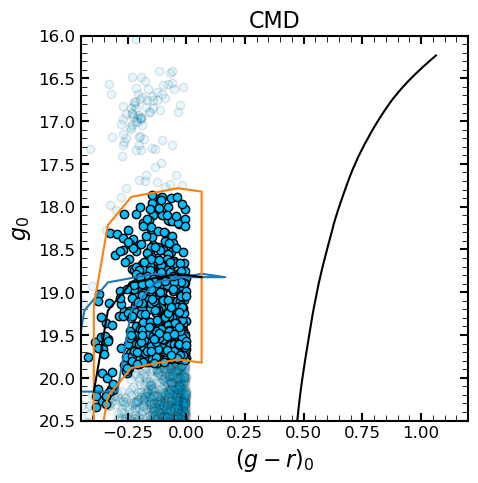

In [134]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(*polygon1.exterior.xy)
ax.plot(*polygon2.exterior.xy)
plot_RGB_isochrone(ax, dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], distance_to_dm(DIST_BOO3*1000), '[Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax, distance_to_dm(DIST_BOO3*1000), c='k')
plot_cmd(fig, ax, boo3_gaia_blue['dered_mag_g'], boo3_gaia_blue['dered_mag_r'], '', c='deepskyblue', ec='k', alpha=0.1)
plot_cmd(fig, ax, boo3_gaia_BHB['dered_mag_g'], boo3_gaia_BHB['dered_mag_r'], '', c='deepskyblue', ec='k')
ax_labels(ax, r'$(g-r)_0$', r'$g_0$', 'CMD')
ax.set_xlim(-0.45, 1.2)
ax.set_ylim(16, 20.5)
ax.invert_yaxis()

In [135]:
append_BHB_dm(boo3_gaia_BHB, 'dered_mag_g', 'dered_mag_r')

These samples don't have RV so we'll just remove the RV vs. RA panel.

In [128]:
def plot_four_curves(ax, orbit_curves, **kwargs):
    ax0_kwargs = kwargs.copy()
    ax0_kwargs.pop('label', None)
    ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **ax0_kwargs)
    ax[1].plot(orbit_curves[1][:,0], orbit_curves[1][:,1], **kwargs)
    ax[2].plot(orbit_curves[2][:,0], orbit_curves[2][:,1], **kwargs)
    ax[3].plot(orbit_curves[4][:,0], orbit_curves[4][:,1], **kwargs)

def plot_gaia_data(ax, data, color, label):
    ax[0].scatter(data['ra'], data['dec'], c=color, label=label, marker='o', ec='k', zorder=2)
    ax[2].errorbar(data['ra'], data['pmdec'], c=color, label=label, fmt='o', mec='k', capsize=0, lw=1)
    ax[1].errorbar(data['ra'], data['pmra'], c=color, label=label, fmt='o', mec='k', capsize=0, lw=1)
    ax[3].scatter(data['ra'], data['dm'], c=color, label=label, marker='o', ec='k', zorder=2)

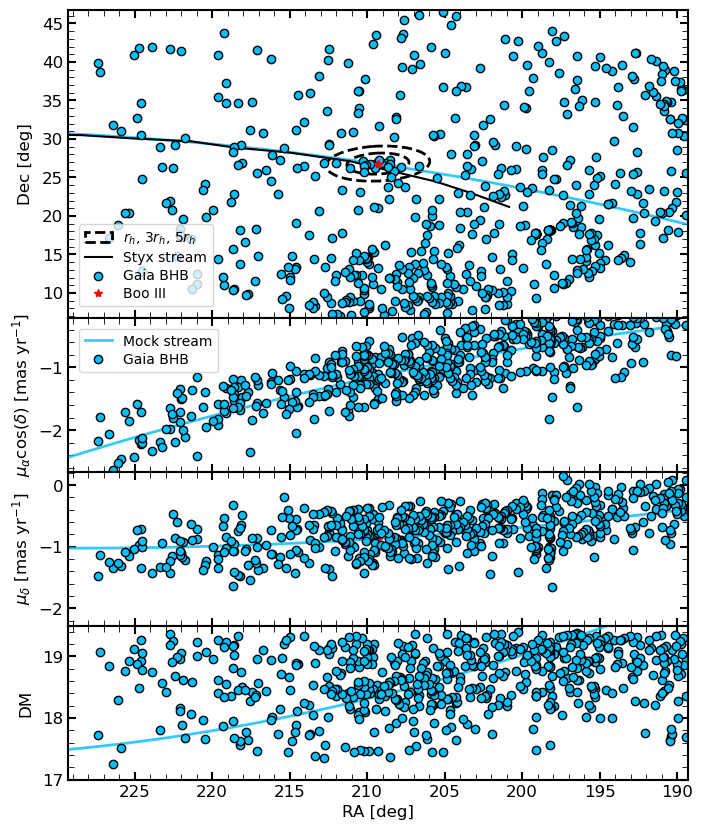

In [156]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
                       gridspec_kw={'height_ratios': [2, 1, 1, 1]})
fig.subplots_adjust(hspace=0)

plot_four_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_onsky(fig, ax[0], boo3_main_members, 'S5', marker='o', c='deepskyblue', ec='k', zorder=2)
# plot_onsky(fig, ax[0], boo3_main_rrl, 'S5 RRL', marker='^', s=60, c='deepskyblue', ec='k', zorder=2)
plot_gaia_data(ax, boo3_gaia_BHB, 'deepskyblue', 'Gaia BHB')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[3].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

In [145]:
def trim_along_curve(data, curve, lower_shift, upper_shift):
    indices1 = data['dec'] < np.interp(data['ra'], curve[:,0], curve[:,1]+upper_shift)
    indices2 = data['dec'] > np.interp(data['ra'], curve[:,0], curve[:,1]+lower_shift)
    
    return data[indices1 & indices2]

In [167]:
boo3_gaia_BHB_cut1 = trim_along_curve(boo3_gaia_BHB, orbit_curves_fiducial[0], -5, 5)
boo3_gaia_BHB_cut2 = trim_along_curve(boo3_gaia_BHB, orbit_curves_fiducial[0], 10, 15)
boo3_gaia_BHB_cut3 = trim_along_curve(boo3_gaia_BHB, orbit_curves_fiducial[0], -15, -10)

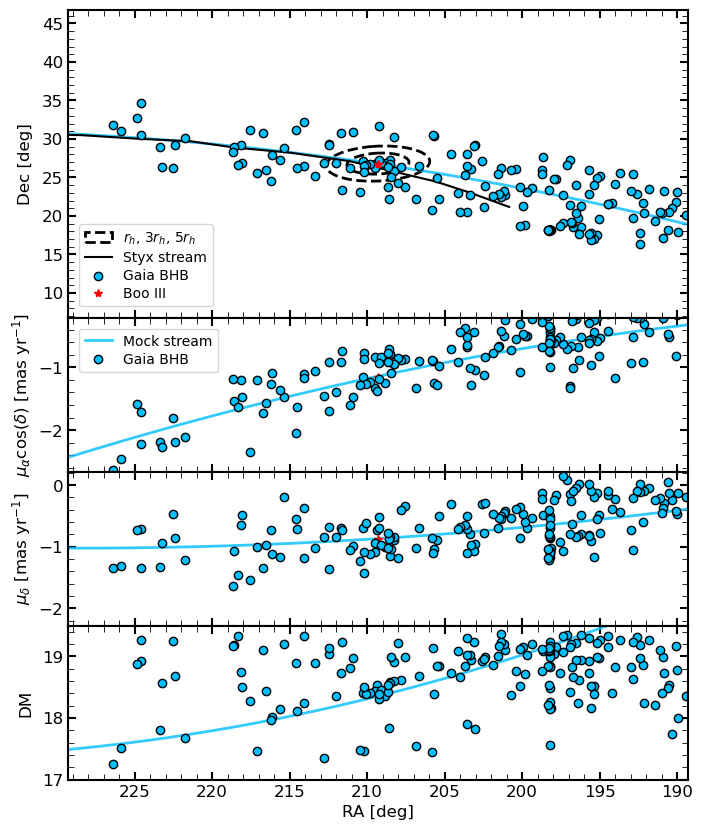

In [204]:
fig1, ax1 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
                       gridspec_kw={'height_ratios': [2, 1, 1, 1]})
fig1.subplots_adjust(hspace=0)

plot_rh(ax1[0])
plot_four_curves(ax1, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
ax1[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_gaia_data(ax1, boo3_gaia_BHB_cut1, 'deepskyblue', 'Gaia BHB')

for ax_i, label, value, scale in zip(ax1, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax1[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax1[3].set_xlabel("RA [deg]", fontsize=12)

fig1.align_ylabels(ax1)
ax1[0].legend(loc='lower left', fontsize=10)
ax1[1].legend(loc='upper left', fontsize=10)
fig1.savefig('bhb_stream.pdf', dpi=300)
plt.show()

In [170]:
# fig1, ax1 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
#                        gridspec_kw={'height_ratios': [2, 1, 1, 1]})
# fig1.subplots_adjust(hspace=0)

# plot_rh(ax1[0])
# plot_four_curves(ax1, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
# ax1[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_gaia_data(ax1, boo3_gaia_BHB_cut1, 'deepskyblue', 'Gaia BHB')

# for ax_i, label, value, scale in zip(ax1, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
#                                      [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
#                                      [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
#                                       (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
#     ax_i.plot(RA_BOO3, value, "*r")
#     ax_i.set_ylabel(label, fontsize=12)
#     ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
#     ax_i.set_ylim(*scale)
#     ax_i.invert_xaxis()
# ax1[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
# ax1[3].set_xlabel("RA [deg]", fontsize=12)

# fig1.align_ylabels(ax1)
# ax1[0].legend(loc='lower left', fontsize=10)
# ax1[1].legend(loc='upper left', fontsize=10)
# plt.show()

# fig2, ax2 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
#                        gridspec_kw={'height_ratios': [2, 1, 1, 1]})
# fig2.subplots_adjust(hspace=0)

# plot_rh(ax2[0])
# plot_four_curves(ax2, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
# ax2[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_gaia_data(ax2, boo3_gaia_BHB_cut2, 'deepskyblue', 'Gaia BHB')

# for ax_i, label, value, scale in zip(ax2, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
#                                      [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
#                                      [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
#                                       (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
#     ax_i.plot(RA_BOO3, value, "*r")
#     ax_i.set_ylabel(label, fontsize=12)
#     ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
#     ax_i.set_ylim(*scale)
#     ax_i.invert_xaxis()
# ax2[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
# ax2[3].set_xlabel("RA [deg]", fontsize=12)

# fig2.align_ylabels(ax2)
# ax2[0].legend(loc='lower left', fontsize=10)
# ax2[1].legend(loc='upper left', fontsize=10)
# plt.show()

# fig3, ax3 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
#                        gridspec_kw={'height_ratios': [2, 1, 1, 1]})
# fig3.subplots_adjust(hspace=0)

# plot_rh(ax3[0])
# plot_four_curves(ax3, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
# ax3[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_gaia_data(ax3, boo3_gaia_BHB_cut3, 'deepskyblue', 'Gaia BHB')

# for ax_i, label, value, scale in zip(ax3, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
#                                      [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
#                                      [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
#                                       (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
#     ax_i.plot(RA_BOO3, value, "*r")
#     ax_i.set_ylabel(label, fontsize=12)
#     ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
#     ax_i.set_ylim(*scale)
#     ax_i.invert_xaxis()
# ax3[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
# ax3[3].set_xlabel("RA [deg]", fontsize=12)

# fig3.align_ylabels(ax3)
# ax3[0].legend(loc='lower left', fontsize=10)
# ax3[1].legend(loc='upper left', fontsize=10)
# plt.show()

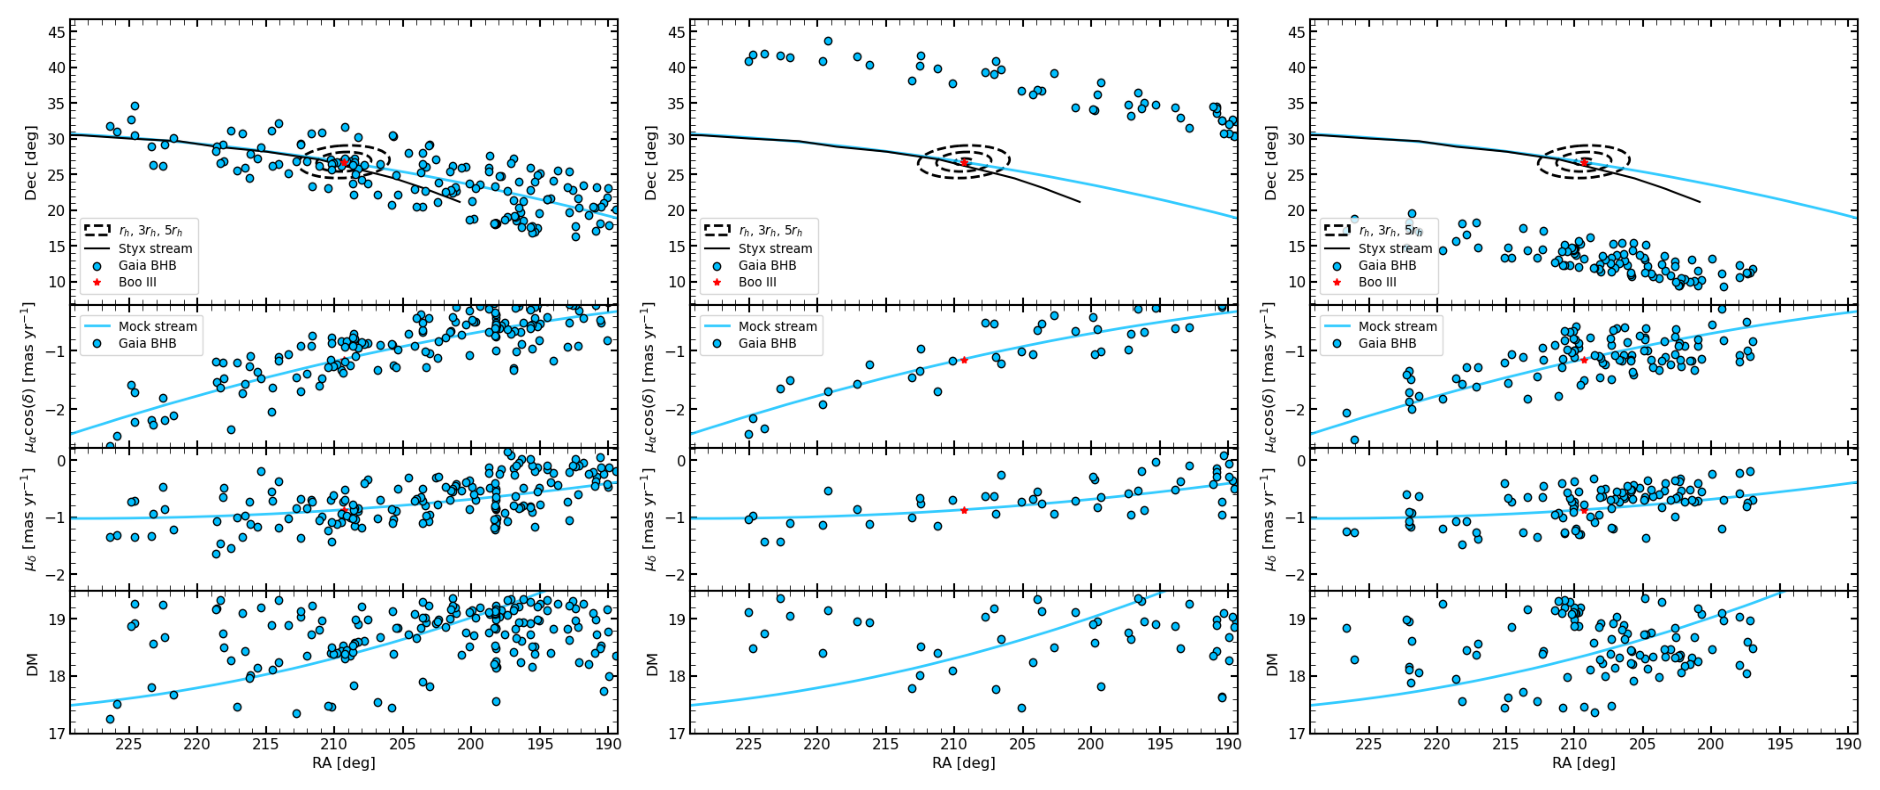

In [169]:
plt.figure(figsize=(24, 10))
plt.subplot(131)
plt.subplots_adjust(wspace=0)
plt.imshow(fig1.canvas.renderer._renderer, aspect='auto')
plt.axis('off')
plt.subplot(132)
plt.subplots_adjust(wspace=0)
plt.imshow(fig2.canvas.renderer._renderer, aspect='auto')
plt.axis('off')
plt.subplot(133)
plt.subplots_adjust(wspace=0)
plt.imshow(fig3.canvas.renderer._renderer, aspect='auto')
plt.axis('off')
plt.show()

## RRL

In [171]:
print("Gaia DR3 RRL catalogue:", len(table_rrl))

table_rrl = angular_radius_cut(table_rrl, [RA_BOO3, DEC_BOO3], 20)
print("Radius cut 20 deg:", len(table_rrl))

ls_matched_to_rrl, sep2d = crossmatch(table_rrl, table_ls, sep_dist=0.5, get_sep2d=True)
table_rrl = table.hstack([table_rrl[sep2d < 0.5*units.arcsec], ls_matched_to_rrl['dered_mag_g'], 
                               ls_matched_to_rrl['dered_mag_r'], ls_matched_to_rrl['dered_mag_z']])
print("Assigning magnitudes:", len(table_rrl))

table_rrl = table_rrl[np.isfinite(table_rrl['pmra']) & np.isfinite(table_rrl['pmdec'])]
print("Remove nan and inf values in PM:", len(table_rrl))

Gaia DR3 RRL catalogue: 271779
Radius cut 20 deg: 2185
Assigning magnitudes: 2080
Remove nan and inf values in PM: 2072


In [173]:
table_rrl_cut = pm_cut_with_gradient(table_rrl, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut:", len(table_rrl_cut))

add_dm_to_RRLs(table_rrl_cut, FEH_BOO3)

boo3_gaia_RRL = table.setdiff(table_rrl_cut, boo3_main_rrl, keys=['source_id'])
print("Removing repeats from S5 base sample:", len(boo3_gaia_RRL))

PM cut: 280
Removing repeats from S5 base sample: 277


In [179]:
boo3_gaia_RRL_cut1 = trim_along_curve(boo3_gaia_RRL, orbit_curves_fiducial[0], -5, 5)
boo3_gaia_RRL_cut2 = trim_along_curve(boo3_gaia_RRL, orbit_curves_fiducial[0], 5, 15)
boo3_gaia_RRL_cut3 = trim_along_curve(boo3_gaia_RRL, orbit_curves_fiducial[0], -15, -5)

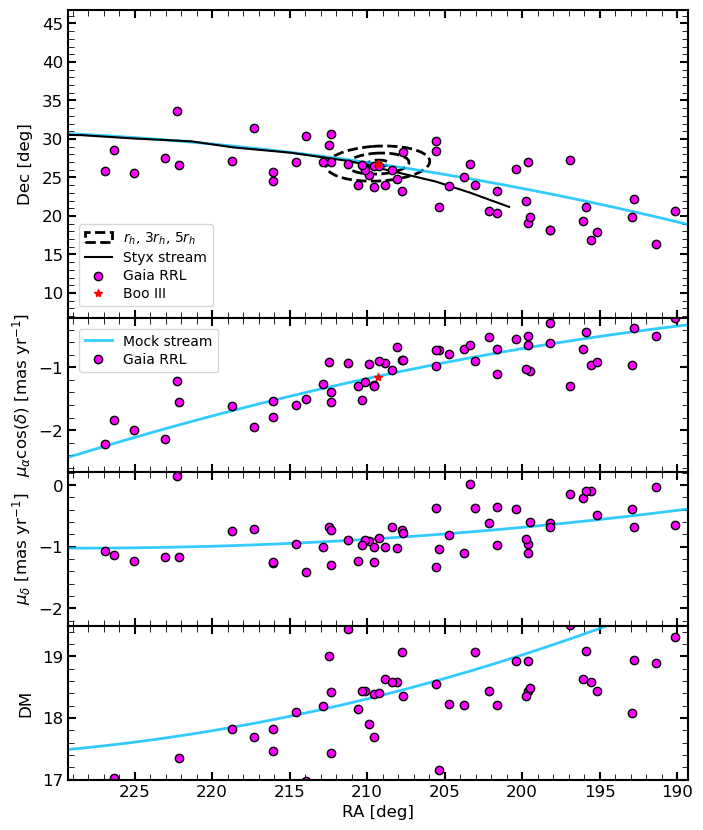

In [203]:
fig1, ax1 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
                       gridspec_kw={'height_ratios': [2, 1, 1, 1]})
fig1.subplots_adjust(hspace=0)

plot_rh(ax1[0])
plot_four_curves(ax1, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
ax1[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_gaia_data(ax1, boo3_gaia_RRL_cut1, 'magenta', 'Gaia RRL')

for ax_i, label, value, scale in zip(ax1, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax1[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax1[3].set_xlabel("RA [deg]", fontsize=12)

fig1.align_ylabels(ax1)
ax1[0].legend(loc='lower left', fontsize=10)
ax1[1].legend(loc='upper left', fontsize=10)
fig1.savefig("rrl_stream.pdf", dpi=300)
plt.show()

In [182]:
# fig1, ax1 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
#                        gridspec_kw={'height_ratios': [2, 1, 1, 1]})
# fig1.subplots_adjust(hspace=0)

# plot_rh(ax1[0])
# plot_four_curves(ax1, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
# ax1[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_gaia_data(ax1, boo3_gaia_RRL_cut1, 'magenta', 'Gaia RRL')

# for ax_i, label, value, scale in zip(ax1, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
#                                      [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
#                                      [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
#                                       (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
#     ax_i.plot(RA_BOO3, value, "*r")
#     ax_i.set_ylabel(label, fontsize=12)
#     ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
#     ax_i.set_ylim(*scale)
#     ax_i.invert_xaxis()
# ax1[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
# ax1[3].set_xlabel("RA [deg]", fontsize=12)

# fig1.align_ylabels(ax1)
# ax1[0].legend(loc='lower left', fontsize=10)
# ax1[1].legend(loc='upper left', fontsize=10)
# plt.show()

# fig2, ax2 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
#                        gridspec_kw={'height_ratios': [2, 1, 1, 1]})
# fig2.subplots_adjust(hspace=0)

# plot_rh(ax2[0])
# plot_four_curves(ax2, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
# ax2[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_gaia_data(ax2, boo3_gaia_RRL_cut2, 'magenta', 'Gaia RRL')

# for ax_i, label, value, scale in zip(ax2, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
#                                      [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
#                                      [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
#                                       (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
#     ax_i.plot(RA_BOO3, value, "*r")
#     ax_i.set_ylabel(label, fontsize=12)
#     ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
#     ax_i.set_ylim(*scale)
#     ax_i.invert_xaxis()
# ax2[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
# ax2[3].set_xlabel("RA [deg]", fontsize=12)

# fig2.align_ylabels(ax2)
# ax2[0].legend(loc='lower left', fontsize=10)
# ax2[1].legend(loc='upper left', fontsize=10)
# plt.show()

# fig3, ax3 = plt.subplots(4, 1, sharex=True, figsize=(8, 10),
#                        gridspec_kw={'height_ratios': [2, 1, 1, 1]})
# fig3.subplots_adjust(hspace=0)

# plot_rh(ax3[0])
# plot_four_curves(ax3, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
# ax3[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# plot_gaia_data(ax3, boo3_gaia_RRL_cut3, 'magenta', 'Gaia RRL')

# for ax_i, label, value, scale in zip(ax3, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
#                                      [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
#                                      [(DEC_BOO3-20, DEC_BOO3+20), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
#                                       (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (17, 19.5)]):
#     ax_i.plot(RA_BOO3, value, "*r")
#     ax_i.set_ylabel(label, fontsize=12)
#     ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
#     ax_i.set_ylim(*scale)
#     ax_i.invert_xaxis()
# ax3[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
# ax3[3].set_xlabel("RA [deg]", fontsize=12)

# fig3.align_ylabels(ax3)
# ax3[0].legend(loc='lower left', fontsize=10)
# ax3[1].legend(loc='upper left', fontsize=10)
# plt.show()

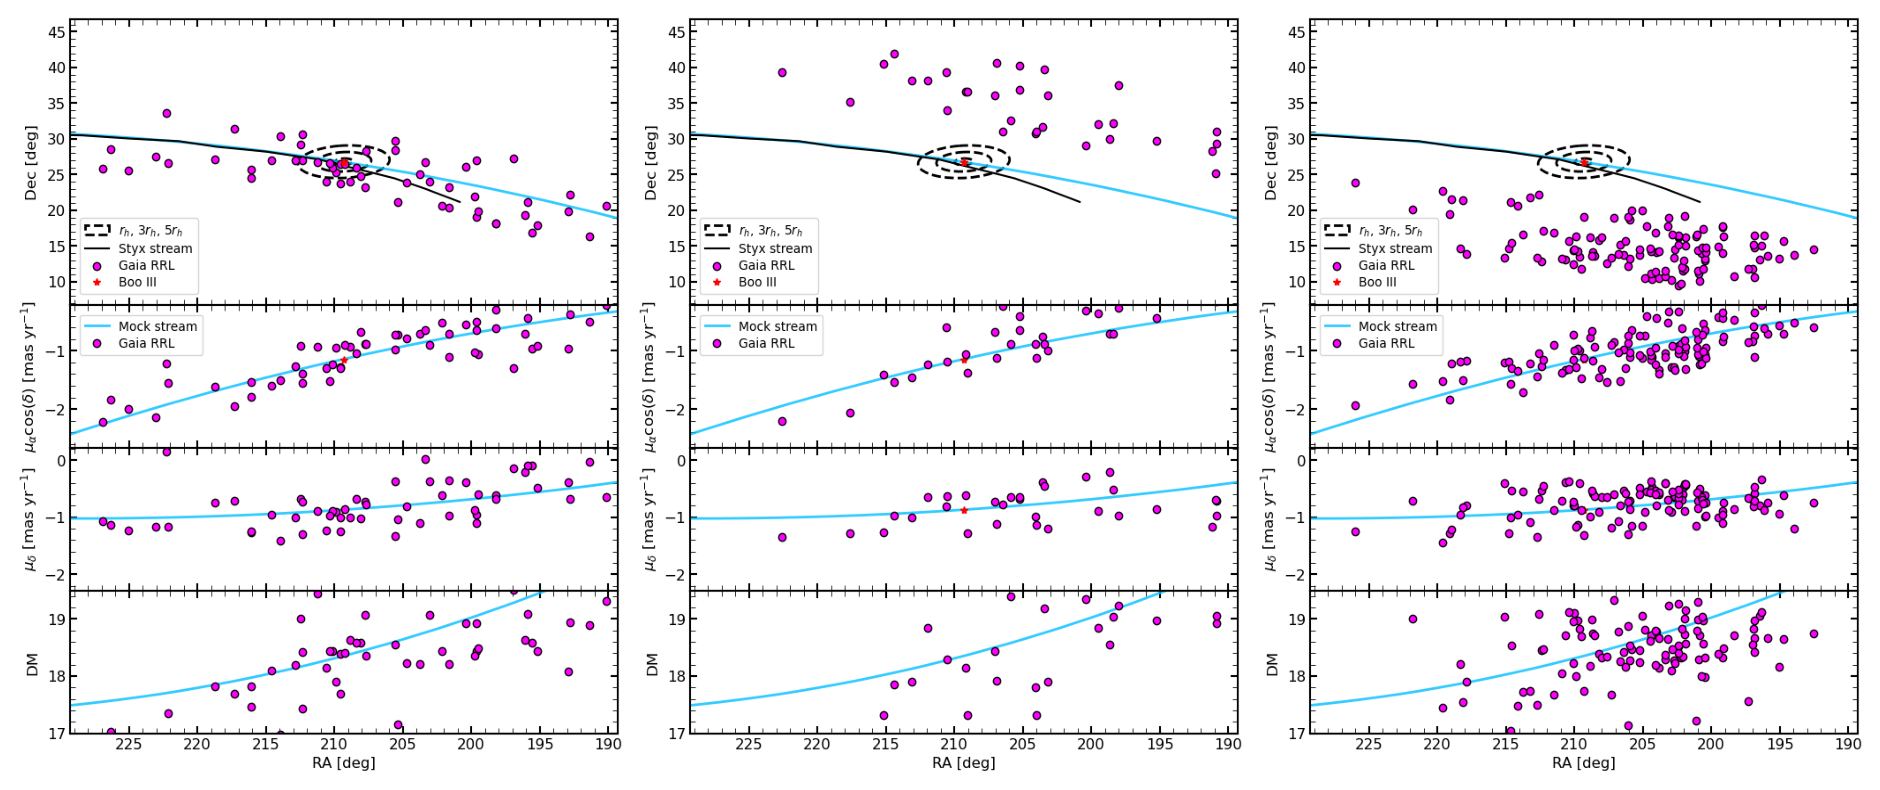

In [181]:
plt.figure(figsize=(24, 10))
plt.subplot(131)
plt.subplots_adjust(wspace=0)
plt.imshow(fig1.canvas.renderer._renderer, aspect='auto')
plt.axis('off')
plt.subplot(132)
plt.subplots_adjust(wspace=0)
plt.imshow(fig2.canvas.renderer._renderer, aspect='auto')
plt.axis('off')
plt.subplot(133)
plt.subplots_adjust(wspace=0)
plt.imshow(fig3.canvas.renderer._renderer, aspect='auto')
plt.axis('off')
plt.show()